In [21]:
import torch
from scipy.cluster.hierarchy import num_obs_linkage

n_dim = 2
n_points = 10
n_labels = 5

points = torch.tensor(range(n_points), dtype=torch.int)
labels = torch.rand((n_points, n_labels)) > 0.4


Our example model is very simplistic. The datapoints are just integers from 0 to `n_points` and randomly assigned `labels`. As a first step, we have to embed our datapoints into an `n_dim`-dimensional space. To this end, we implement a simple embedding model that assigns each integer with an `n_dim`-dimensional point. For more complex applications, this embedding model has to be tailored towards the specific input data.

In [22]:
class SimpleEmbedding(torch.nn.Module):
    def __init__(self, n_points, n_dim):
        super(SimpleEmbedding, self).__init__()
        self.out_dim = n_dim
        self.points = torch.rand((n_points, n_dim))*6-3

    def forward(self, idx):
        return self.points[idx]

embedding_model = SimpleEmbedding(n_points, n_dim)
embeddings = embedding_model(points)

For `n_dim == 2`, we can plot the spacial positions of these points:

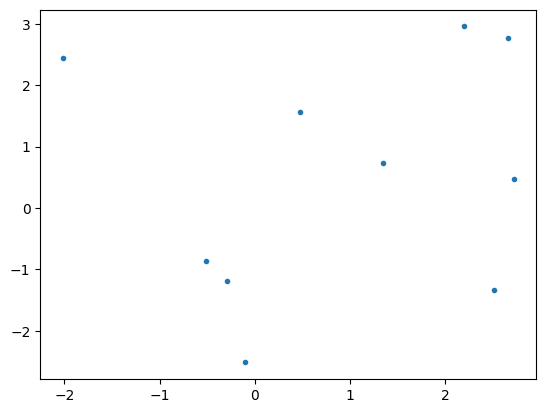

<Figure size 640x480 with 0 Axes>

In [23]:
from potemkin.io.render import draw_2d
draw_2d(embeddings)

Next, we need to build the town model based on the embedding model. For presentation purposes, a unique color is assigned to each class.

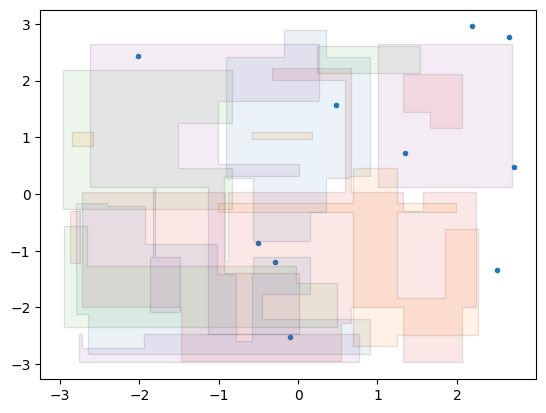

<Figure size 640x480 with 0 Axes>

In [24]:
from potemkin.models.town_model import TownModel
from matplotlib import colormaps
model = TownModel(embedding_model, n_labels)
cmap = colormaps["Set1"]
colors = list(cmap.colors)[:n_labels]

draw_2d(embeddings, model, town_colors=colors)

Passing the datapoints to the model calculates the containment for each frame, window and town, as well as inner and outer distances for frames and windows.

In [25]:
model_out = model(points)
model_out.keys()

dict_keys(['embeddings', 'crisp_frame_containment', 'crisp_window_containment', 'crisp_house_containment', 'crisp_containment', 'inner_frame_distance', 'outer_frame_distance', 'inner_window_distances', 'outer_window_distances'])

These values are used to calculate the loss.

In [26]:
from potemkin.loss.town_loss import DistanceLoss

loss_fn = DistanceLoss()

loss = loss_fn(model_out, labels)

loss

tensor(0.9351, grad_fn=<MeanBackward0>)

In [27]:
containment = model_out['crisp_containment']

accuracy = (containment==labels).float().mean(dim=-1)

accuracy

tensor([0.8000, 0.4000, 0.6000, 1.0000, 0.2000, 0.4000, 0.8000, 0.6000, 0.4000,
        0.4000])

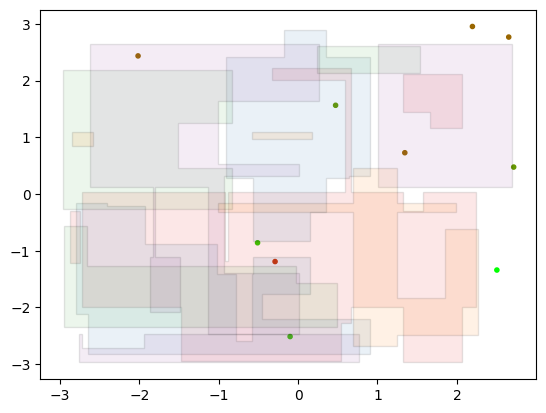

<Figure size 640x480 with 0 Axes>

In [28]:
point_colors = torch.stack((1-accuracy, accuracy, 0*accuracy)).T.tolist()

draw_2d(embeddings, model, point_colors=point_colors, town_colors=colors)